In [1]:
import pandas as pd
import os

os.chdir('../..')
DATA_PATH = 'data/processed/'

In [76]:
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
pd.set_option('display.max_columns', None)

In [4]:
full_data = pd.read_pickle(DATA_PATH + 'gameweek_data.pkl')
print(full_data.shape)
full_data.head()

(67910, 64)


,clean_name,pos,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,element,errors_leading_to_goal,errors_leading_to_goal_attempt,fixture,fouls,goals_conceded,goals_scored,ict_index,id,influence,key_passes,kickoff_time,kickoff_time_formatted,loaned_in,loaned_out,minutes,offside,open_play_crosses,opponent_team,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,round,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,season_num,position_DEF,position_FWD,position_GK,position_MID
0,David_Ospina,GK,David_Ospina,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,0,8,0,0,0,0.0,1,0.0,0,2016-08-14T15:00:00Z,14 Aug 16:00,0,0,0,0,0,9,0,0,0,0,0,0,1,0,6064,0,0,0,4,3,0.0,0,0,0,0,50,True,0,0,1,2016-17,1,0,0,1,0
1,David_Ospina,GK,David_Ospina,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,0,13,0,0,0,0.0,526,0.0,0,2016-08-20T16:30:00Z,20 Aug 17:30,0,0,0,0,0,8,0,0,0,0,0,0,2,0,7400,0,0,0,0,0,0.0,0,-578,153,731,50,False,0,0,2,2016-17,1,0,0,1,0
2,David_Ospina,GK,David_Ospina,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,0,28,0,0,0,0.0,1066,0.0,0,2016-08-27T14:00:00Z,27 Aug 15:00,0,0,0,0,0,18,0,0,0,0,0,0,3,0,7708,0,0,0,3,1,0.0,0,-571,150,721,50,False,0,0,3,2016-17,1,1,0,0,0
3,David_Ospina,GK,David_Ospina,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,0,31,0,0,0,0.0,1616,0.0,0,2016-09-10T14:00:00Z,10 Sep 15:00,0,0,0,0,0,13,0,0,0,0,0,0,4,0,8072,0,0,0,1,2,0.0,0,-449,183,632,49,True,0,0,4,2016-17,1,1,0,0,0
4,David_Ospina,GK,David_Ospina,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,0,43,0,0,0,0.0,2197,0.0,0,2016-09-17T14:00:00Z,17 Sep 15:00,0,0,0,0,0,7,0,0,0,0,0,0,5,0,8379,0,0,0,4,1,0.0,0,-158,172,330,49,False,0,0,5,2016-17,1,1,0,0,0


In [5]:
full_data['season'].unique()

array(['2016-17', '2017-18', '2018-19'], dtype=object)

In [7]:
# Drop 2018-19 season data
training_data = full_data.copy()[full_data['season'] != '2018-19']

In [10]:
training_data.sort_values(by=['clean_name','season_num','gw'], inplace=True)

In [11]:
training_data.head()

,clean_name,pos,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,element,errors_leading_to_goal,errors_leading_to_goal_attempt,fixture,fouls,goals_conceded,goals_scored,ict_index,id,influence,key_passes,kickoff_time,kickoff_time_formatted,loaned_in,loaned_out,minutes,offside,open_play_crosses,opponent_team,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,round,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,season_num,position_DEF,position_FWD,position_GK,position_MID
37603,Aaron_Cresswell,DEF,Aaron_Cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,454,0,0,10,0,0,0,0.0,454,0.0,0,2016-08-15T19:00:00Z,15 Aug 20:00,0,0,0,0,0,4,0,0,0,0,0,0,1,0,14023,0,0,0,1,2,0.0,0,0,0,0,55,False,0,0,1,2016-17,1,0,0,0,0
37604,Aaron_Cresswell,DEF,Aaron_Cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,454,0,0,20,0,0,0,0.0,979,0.0,0,2016-08-21T15:00:00Z,21 Aug 16:00,0,0,0,0,0,2,0,0,0,0,0,0,2,0,11531,0,0,0,0,1,0.0,0,-3002,79,3081,55,True,0,0,2,2016-17,1,0,0,0,0
37605,Aaron_Cresswell,DEF,Aaron_Cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,454,0,0,29,0,0,0,0.0,1519,0.0,0,2016-08-28T15:00:00Z,28 Aug 16:00,0,0,0,0,0,10,0,0,0,0,0,0,3,0,9587,0,0,0,1,3,0.0,0,-2053,28,2081,54,False,0,0,3,2016-17,1,0,0,0,0
37606,Aaron_Cresswell,DEF,Aaron_Cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,454,0,0,38,0,0,0,0.0,2069,0.0,0,2016-09-10T14:00:00Z,10 Sep 15:00,0,0,0,0,0,18,0,0,0,0,0,0,4,0,8427,0,0,0,4,2,0.0,0,-1221,45,1266,54,True,0,0,4,2016-17,1,0,0,0,0
37607,Aaron_Cresswell,DEF,Aaron_Cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,454,0,0,46,0,0,0,0.0,2650,0.0,0,2016-09-17T14:00:00Z,17 Sep 15:00,0,0,0,0,0,19,0,0,0,0,0,0,5,0,7933,0,0,0,2,4,0.0,0,-520,29,549,54,False,0,0,5,2016-17,1,0,0,0,0


In [23]:
data_1617 = training_data.copy()[training_data['season'] == '2016-17']

In [24]:
data_1617['season'].unique()

array(['2016-17'], dtype=object)

In [25]:
def preprocess_data(df):
    df.drop(['pos', 'name', 'element', 'id', 'kickoff_time', 'kickoff_time_formatted', 'season'], axis=1, inplace=True)

In [26]:
preprocess_data(data_1617)
data_1617.head()

,clean_name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,errors_leading_to_goal,errors_leading_to_goal_attempt,fixture,fouls,goals_conceded,goals_scored,ict_index,influence,key_passes,loaned_in,loaned_out,minutes,offside,open_play_crosses,opponent_team,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,round,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season_num,position_DEF,position_FWD,position_GK,position_MID
37603,Aaron_Cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,10,0,0,0,0.0,0.0,0,0,0,0,0,0,4,0,0,0,0,0,0,1,0,14023,0,0,0,1,2,0.0,0,0,0,0,55,False,0,0,1,1,0,0,0,0
37604,Aaron_Cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,20,0,0,0,0.0,0.0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0,11531,0,0,0,0,1,0.0,0,-3002,79,3081,55,True,0,0,2,1,0,0,0,0
37605,Aaron_Cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,29,0,0,0,0.0,0.0,0,0,0,0,0,0,10,0,0,0,0,0,0,3,0,9587,0,0,0,1,3,0.0,0,-2053,28,2081,54,False,0,0,3,1,0,0,0,0
37606,Aaron_Cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,38,0,0,0,0.0,0.0,0,0,0,0,0,0,18,0,0,0,0,0,0,4,0,8427,0,0,0,4,2,0.0,0,-1221,45,1266,54,True,0,0,4,1,0,0,0,0
37607,Aaron_Cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,46,0,0,0,0.0,0.0,0,0,0,0,0,0,19,0,0,0,0,0,0,5,0,7933,0,0,0,2,4,0.0,0,-520,29,549,54,False,0,0,5,1,0,0,0,0


### Baseline

In [34]:
mean_points_by_player = data_1617.groupby(['clean_name']).mean()['total_points'].reset_index()
mean_points_by_player.rename(columns={'total_points': 'mean_pts_per_gw'}, inplace=True)
mean_points_by_player.head()

,clean_name,mean_pts_per_gw
0,Aaron_Cresswell,1.578947
1,Aaron_Lennon,0.578947
2,Aaron_Ramsdale,0.000000
3,Aaron_Ramsey,1.473684
4,Aaron_Wan-Bissaka,0.000000


In [36]:
baseline_data = data_1617.merge(mean_points_by_player, how='left', on='clean_name')

In [38]:
baseline_mse = mean_squared_error(baseline_data['total_points'], baseline_data['mean_pts_per_gw'])
baseline_mse

4.380535328845672

### XGBoost on existing data (no additional features)

In [27]:
xgb_model = xgb.XGBRegressor()

In [28]:
xgb_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [29]:
xgb_model.fit(data_1617.drop(['total_points', 'clean_name'], axis=1), data_1617['total_points'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [43]:
xgb_predictions = xgb_model.predict(data_1617.drop(['total_points', 'clean_name'], axis=1))

In [44]:
xgb_mse = mean_squared_error(data_1617['total_points'], xgb_predictions)
xgb_mse

0.1334321864968266

In [45]:
data_1617['xgb_predictions'] = xgb_predictions

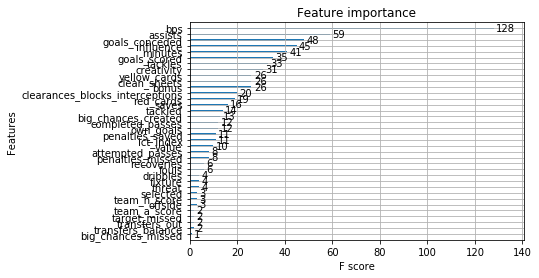

In [53]:
plot_importance(xgb_model)

In [57]:
data_1617.drop('xgb_predictions', axis=1, inplace=True)

In [83]:
# Taken from https://towardsdatascience.com/time-series-machine-learning-regression-framework-9ea33929009a

class ToSupervised(BaseEstimator, TransformerMixin):
    
    def __init__(self,col,groupCol,numLags,dropna=False):
        
        self.col = col
        self.groupCol = groupCol
        self.numLags = numLags
        self.dropna = dropna
        
    def fit(self,X,y=None):
        self.X = X
        return self
    
    def transform(self,X):
        tmp = self.X.copy()
        for i in range(1,self.numLags+1):
            tmp[str(i)+'_GW_Ago'+"_"+self.col] = tmp.groupby([self.groupCol])[self.col].shift(i) 
            
        if self.dropna:
            tmp = tmp.dropna()
            tmp = tmp.reset_index(drop=True)

        return tmp

class ToSupervisedDiff(BaseEstimator, TransformerMixin):
    
    def __init__(self,col,groupCol,numLags,dropna=False):
        
        self.col = col
        self.groupCol = groupCol
        self.numLags = numLags
        self.dropna = dropna
        
    def fit(self,X,y=None):
        self.X = X
        return self
    
    def transform(self,X):
        tmp = self.X.copy()
        for i in range(1,self.numLags+1):
            tmp[str(i)+'_GW_Ago_Diff_'+"_"+self.col] = tmp.groupby([self.groupCol])[self.col].diff(i) 
            
        if self.dropna:
            tmp = tmp.dropna()
            tmp = tmp.reset_index(drop=True)
            
        return tmp

In [101]:
data_1617.columns

Index(['clean_name', 'assists', 'attempted_passes', 'big_chances_created',
       'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
       'clearances_blocks_interceptions', 'completed_passes', 'creativity',
       'dribbles', 'ea_index', 'errors_leading_to_goal',
       'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
       'goals_scored', 'ict_index', 'influence', 'key_passes', 'loaned_in',
       'loaned_out', 'minutes', 'offside', 'open_play_crosses',
       'opponent_team', 'own_goals', 'penalties_conceded', 'penalties_missed',
       'penalties_saved', 'recoveries', 'red_cards', 'round', 'saves',
       'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
       'team_h_score', 'threat', 'total_points', 'transfers_balance',
       'transfers_in', 'transfers_out', 'value', 'was_home', 'winning_goals',
       'yellow_cards', 'gw', 'season_num', 'position_DEF', 'position_FWD',
       'position_GK', 'position_MID'],
      dtype='object')

In [93]:
# 2 lags and 2 diff for all variables (rather than 1 for some and 2 for others)
steps_lag = []
for col_name in ['assists', 'attempted_passes']:
    for number in np.arange(1,3):
        steps_lag.append(
            (f'{number}_lag_{col_name}', ToSupervised(col=col_name, groupCol='clean_name', numLags=number, dropna=False))
        )

steps_diff = []
for col_name in ['assists', 'attempted_passes']:
    for number in np.arange(1,3):
        steps_diff.append(
            (f'{number}_diff_{col_name}', ToSupervisedDiff(col=col_name, groupCol='clean_name', numLags=number, dropna=False))
        )

In [94]:
steps_lag

[('1_lag_assists',
  ToSupervised(col='assists', dropna=False, groupCol='clean_name', numLags=1)),
 ('2_lag_assists',
  ToSupervised(col='assists', dropna=False, groupCol='clean_name', numLags=2)),
 ('1_lag_attempted_passes',
  ToSupervised(col='attempted_passes', dropna=False, groupCol='clean_name',
         numLags=1)),
 ('2_lag_attempted_passes',
  ToSupervised(col='attempted_passes', dropna=False, groupCol='clean_name',
         numLags=2))]

In [95]:
lag_transformer = Pipeline(steps=steps_lag)

diff_transformer = Pipeline(steps=steps_diff)

In [96]:
pipe = Pipeline(steps=[
    ('lagged_variables', lag_transformer),
    ('diff_variables', diff_transformer)
                      ]
               )

In [102]:
test = pipe.fit_transform(data_1617)
test.head()

,clean_name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,errors_leading_to_goal,errors_leading_to_goal_attempt,fixture,fouls,goals_conceded,goals_scored,ict_index,influence,key_passes,loaned_in,loaned_out,minutes,offside,open_play_crosses,opponent_team,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,round,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season_num,position_DEF,position_FWD,position_GK,position_MID,1_GW_Ago_assists,2_GW_Ago_assists,1_GW_Ago_attempted_passes,2_GW_Ago_attempted_passes,1_GW_Ago_Diff__assists,2_GW_Ago_Diff__assists,1_GW_Ago_Diff__attempted_passes,2_GW_Ago_Diff__attempted_passes
37603,Aaron_Cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,10,0,0,0,0.0,0.0,0,0,0,0,0,0,4,0,0,0,0,0,0,1,0,14023,0,0,0,1,2,0.0,0,0,0,0,55,False,0,0,1,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37604,Aaron_Cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,20,0,0,0,0.0,0.0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0,11531,0,0,0,0,1,0.0,0,-3002,79,3081,55,True,0,0,2,1,0,0,0,0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
37605,Aaron_Cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,29,0,0,0,0.0,0.0,0,0,0,0,0,0,10,0,0,0,0,0,0,3,0,9587,0,0,0,1,3,0.0,0,-2053,28,2081,54,False,0,0,3,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37606,Aaron_Cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,38,0,0,0,0.0,0.0,0,0,0,0,0,0,18,0,0,0,0,0,0,4,0,8427,0,0,0,4,2,0.0,0,-1221,45,1266,54,True,0,0,4,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37607,Aaron_Cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,46,0,0,0,0.0,0.0,0,0,0,0,0,0,19,0,0,0,0,0,0,5,0,7933,0,0,0,2,4,0.0,0,-520,29,549,54,False,0,0,5,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


To do:
- Create list of column names to be used as lagged and diff variables
- Run XGBoost on data and calculate MSE (can try LGMB if slow)
- Use pipeline to find best hyperparameters (possibly with PCA step to speed up)
- Apply some form of cross validation
- Try setting up pipeline so different variables can have different lags/differences (and then can use grid search to find best combination)